In [247]:
import pandas as pd
import numpy as np

# Note: These files have been exported from the Analysis > Donor section of the AEC periodic disclosures website.
# If you spot anything I may have missed in the below working, please email me: jacksog (at) sbs.com.au.

list_ = []

for fil in ['1213','1314','1415','1516']:
    df1 = pd.read_csv(fil+'.csv',skiprows=2,index_col=None)
    list_.append(df1)
df = pd.concat(list_)

In [241]:
# This is how I allocated donations to either Coalition or Labor based on the recipient name.
def partyer(x):
    if x.lower().find('lib') != -1:
        if x.lower().find('democratic') == -1:
            if x.lower().find('alliance') == -1:
                return 'Coalition'
    elif x.lower().find('lab') != -1:
        if x.lower().find('democratic') == -1:
            return 'Labor'
    elif x.lower().find('alp') != -1:
        return 'Labor'
    elif x.lower().find('lnp') != -1:
        return 'Coalition'
    else:
        if x.lower().find('nat') != -1:
            return 'Coalition'
        elif x == 'Kooyong 200':
            return 'Coalition'
        elif x.lower().find('progressive business') != -1:
            return 'Labor'
        elif x == 'Enterprise 500 Victoria':
            return 'Coalition'
        elif x == 'John McEwen House Pty Ltd':
            return 'Coalition'
        elif x == 'Enterprise 500':
            return 'Coalition'
        elif x == 'STURT FEC':
            return 'Labor'
        else:
            return np.nan


In [242]:
# Testing for false positives
check = []
for test in df['RecipientClientNm'].unique():
    if partyer(test) == 'Coalition':
        check.append([test,'Co'])
    elif partyer(test) == 'Labor':
        check.append([test,'La'])
sorted(check)

[['ALP', 'La'],
 ['ALP (2014 Fed Budget Reply Dinner)', 'La'],
 ['ALP (ACT)', 'La'],
 ['ALP (Dinner PM Kevin Rudd)', 'La'],
 ['ALP (FED)', 'La'],
 ['ALP (Fed)', 'La'],
 ['ALP (Griffith FEC)', 'La'],
 ['ALP (Membership of Federal Labor Business Forum)', 'La'],
 ['ALP (NSW Branch) Blaxland FCA - ALP-NSW', 'La'],
 ['ALP (NSW Branch) McMahon FCA - ALP-NSW', 'La'],
 ['ALP (National Secretariat - Gary Gray Event on 07/07/2014)', 'La'],
 ['ALP (VIC) (Dinner held by Progressive Business)', 'La'],
 ['ALP (VIC) (Dinnwe held by Progressive Business)', 'La'],
 ['ALP (VIC) (Subscription to Progressive Business)', 'La'],
 ['ALP (WA)', 'La'],
 ['ALP - ALP Ministerial Forum - Sydney', 'La'],
 ['ALP - Australian Labor Party', 'La'],
 ['ALP - Australian Labor Party (National Secretariat)', 'La'],
 ['ALP - Boardroom Dinner Bill Shorten', 'La'],
 ['ALP - Business Forum ALP Federal', 'La'],
 ['ALP - Chifley Research Centre', 'La'],
 ['ALP - FED', 'La'],
 ['ALP - FED (2016 Federal Conference - Business prog

In [250]:
# Let's apply our function to the dataframe.
df['Party'] = df['RecipientClientNm'].apply(partyer)

In [251]:
# Checking records missed by the partyer function.
df[df['Party'].isnull()]['RecipientClientNm'].sort_values().unique()

array(['#Sustainable Australia', '#Sustainable Population Party',
       'AFLP. Aust Fishing & Lifestyle Party', 'Australian Christians',
       'Australian Christians - ACH',
       'Australian Equality Party (Marriage)',
       'Australian Fishing & Lifestyle Party',
       'Australian Fishing and Lifestyle Party', 'Australian Greens',
       'Australian Greens (South Australia)',
       'Australian Greens, Australian Capital Territory Branch',
       'Australian Greens, Australian Capital Territory Branch (GRN-ACT)',
       'Australian Greens, Tasmanian Branch',
       'Australian Greens, Victorian Branch',
       'Australian Liberty Alliance',
       'Australian Recreational Fishers Party', 'Australian Sex Party',
       'Australian Stable Population Party', 'CDP', 'CEC', 'CLP', 'CLP-NT',
       'Christian Democratic Party (Fred Nile Group)',
       'Citizens Electoral Council of Australia', 'Country Alliance',
       'DLP-VIC', 'Democratic Labor Party (DLP) - Queensland Branch',
 

In [252]:
# Preparing to the new dataframe
%pylab inline
import seaborn
df1 = df[df['Party'].notnull()]
df1 = df1[['DonationDt','DonorClientNm','RecipientClientNm','AmountPaid','Party']]
df1.DonationDt = pd.to_datetime(df1.DonationDt,dayfirst=True)

Populating the interactive namespace from numpy and matplotlib


In [253]:
# These mark each donation with a figure for the number of days before one of the elections
df1['Days2016'] = datetime.date(2016,7,2) - df1.DonationDt
df1['Days2013'] = datetime.date(2013,9,7) - df1.DonationDt

In [331]:
# Now we go through the four leaders. Yes I know I'm repeating myself, but it makes it easier for sanity checks.
turnbull = df1[df1['Party']=='Coalition']
turnbull = turnbull[turnbull['Days2016']<datetime.timedelta(days=289)]
turnbull = turnbull[turnbull['Days2016']>datetime.timedelta(days=1)]
t = pd.DataFrame(turnbull.groupby('Days2016')['AmountPaid'].sum().sort_index(ascending=False).cumsum())
t["Leader"] = 'Turnbull'

In [332]:
shorten = df1[df1['Party']=='Labor']
shorten = shorten[shorten['Days2016']<datetime.timedelta(days=289)]
shorten = shorten[shorten['Days2016']>datetime.timedelta(days=1)]
s = pd.DataFrame(shorten.groupby('Days2016')['AmountPaid'].sum().sort_index(ascending=False).cumsum())
s["Leader"] = 'Shorten'

In [333]:
abbott = df1[df1['Party']=='Coalition']
abbott = abbott[abbott['Days2013']<datetime.timedelta(days=289)]
abbott = abbott[abbott['Days2013']>datetime.timedelta(days=1)]
a = pd.DataFrame(abbott.groupby('Days2013')['AmountPaid'].sum().sort_index(ascending=False).cumsum())
a['Leader'] = 'Abbott'

In [334]:
rudd = df1[df1['Party']=='Labor']
rudd = rudd[rudd['Days2013']<datetime.timedelta(days=289)]
rudd = rudd[rudd['Days2013']>datetime.timedelta(days=1)]
r = pd.DataFrame(rudd.groupby('Days2013')['AmountPaid'].sum().sort_index(ascending=False).cumsum())
r['Leader'] = 'Rudd'

In [398]:
# Combine the dataframes for each leader and make our final dataframe.
dff = pd.concat([t,s,a,r])

four = dff.reset_index().groupby(['index','Leader']).sum().unstack(level=1).sort_index(ascending=False).fillna(method='ffill')
four = four.reset_index()
four['index'] = four['index'].apply(lambda x: x.days)
four = four.set_index('index')
four.columns = four.columns.droplevel()
four.columns = ['Abbott 2013','Gillard/Rudd 2013','Shorten 2016','Turnbull 2016']
four=four[['Abbott 2013','Turnbull 2016','Gillard/Rudd 2013','Shorten 2016',]]

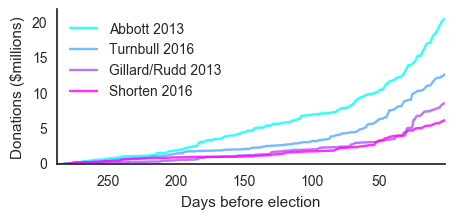

In [405]:
#And visualise
import matplotlib.pyplot as plt
seaborn.set_style('white')
fig = (four/1000000).plot(figsize=(5,2),cmap='cool',alpha=0.8)
#fig.set_title('40 weeks of pre-election donations')
fig.set_xlabel('Days before election')
fig.set_ylabel('Donations ($millions)')
fig.set_ylim(0,22)
seaborn.despine(top=True)
plt.savefig('donations.svg')

In [397]:
four

,Abbott 2013,Gillard/Rudd 2013,Shorten 2016,Turnbull 2016
index,,,,
288,1750.000,4339.000,1825.000,2250.000
287,1940.000,4339.000,1825.000,2250.000
286,12940.000,4339.000,1825.000,2250.000
285,14256.000,4589.000,7325.000,2250.000
284,86256.000,8664.000,12825.000,4450.000
283,110406.000,12964.000,39425.000,47762.000
282,120888.000,23964.000,56320.000,48762.000
281,134163.000,35285.000,109720.000,48762.000
280,140908.000,35285.000,109720.000,48762.000
